<a href="https://colab.research.google.com/github/moises-victor/ML_practioner/blob/main/Deteccao_Classificacao/Deteccao_Classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install MTCNN

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [32]:
from mtcnn import MTCNN
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

import numpy as np
import cv2
import random

### Carregar e Pré-processar os Dados

Vamos usar o ImageDataGenerator do Keras para carregar e aumentar os dados.

In [33]:
SEED = 2

# Definir a semente para reprodutibilidade
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [34]:
# Parâmetros
IMG_SIZE = (224, 224)  # Tamanho das imagens
BATCH_SIZE = 32
DATA_DIR = "/content/drive/MyDrive/Deteccao_Classificacao/dataset/treino"  # Diretório do dataset

# Geradores de dados para treino e validação (Data Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
    # preprocessing_function=preprocess_input,  # Pré-processamento específico
    # rescale=1./255,  # Normalizar os pixels para [0, 1]
    # rotation_range=20,  # Aumento de dados: rotação
    # width_shift_range=0.2,  # Aumento de dados: deslocamento horizontal
    # height_shift_range=0.2,  # Aumento de dados: deslocamento vertical
    # shear_range=0.2,  # Aumento de dados: cisalhamento
    # zoom_range=0.2,  # Aumento de dados: zoom
    # horizontal_flip=True,  # Aumento de dados: espelhamento horizontal
    # brightness_range=[0.8, 1.2], # Variação de brilho
    # validation_split=0.2  # 20% dos dados para validação
)

In [35]:
# Criar o dataset de treinamento e validação
train_dataset = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_dataset = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Verificar as classes detectadas
print("Classes:", train_dataset .class_indices)

Found 32 images belonging to 2 classes.
Found 7 images belonging to 2 classes.
Classes: {'breno': 0, 'moises': 1}


### Carregar um Modelo Pré-treinado

Vamos usar o MobileNetV2 como modelo base e adicionar camadas personalizadas para a classificação.

In [22]:
# Carregar o modelo MobileNetV2
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar todas as camadas exceto as últimas 20
# for layer in base_model.layers:
#     layer.trainable = True

base_model.trainable = False

In [36]:
# Nova camada de saída (3 classes)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 neurônios para 2 classes
])

In [37]:
# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Loss para múltiplas classes
    metrics=['accuracy']
)

# Resumo do modelo
# model.summary()

history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // 32,
    epochs=10,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.4688 - loss: 0.9555 - val_accuracy: 0.5714 - val_loss: 1.4389
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6250 - loss: 0.5505 - val_accuracy: 0.5714 - val_loss: 1.3908
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9375 - loss: 0.2848 - val_accuracy: 0.5714 - val_loss: 1.8811
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9062 - loss: 0.2972 - val_accuracy: 0.5714 - val_loss: 2.2541
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9688 - loss: 0.0945 - val_accuracy: 0.5714 - val_loss: 2.8949
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0458 - val_accuracy: 0.7143 - val_loss: 2.6530
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9688 - loss: 0.0490 - val_accuracy: 0.7143 - val_loss: 1.4881
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.7143 - val_loss: 1.6707
Epoch 9/10
1/1

In [38]:
# base_model.trainable = True  # Permite ajuste fino

# for layer in base_model.layers[:-10]:  # Mantém as primeiras camadas congeladas
#     layer.trainable = False

# history = model.fit(
#     train_dataset,
#     steps_per_epoch=train_dataset.samples // 32,
#     validation_data=validation_dataset,
#     validation_steps=validation_dataset.samples // 32,
#     epochs=10,
# )

In [39]:
# base_model.trainable = True  # Permite ajuste fino

# for layer in base_model.layers[:-20]:  # Mantém as primeiras camadas congeladas
#     layer.trainable = False

# history = model.fit(
#     train_dataset,
#     steps_per_epoch=train_dataset.samples // 32,
#     validation_data=validation_dataset,
#     validation_steps=validation_dataset.samples // 32,
#     epochs=10,
# )

In [40]:
# base_model.trainable = True  # Permite ajuste fino

# for layer in base_model.layers[:-30]:  # Mantém as primeiras camadas congeladas
#     layer.trainable = False

# history = model.fit(
#     train_dataset,
#     steps_per_epoch=train_dataset.samples // 32,
#     validation_data=validation_dataset,
#     validation_steps=validation_dataset.samples // 32,
#     epochs=10,
# )

In [41]:
# # Callbacks para salvar o melhor modelo e parar o treinamento antecipadamente
# checkpoint = ModelCheckpoint(
#     monitor='val_accuracy',
#     save_best_only=True,
#     mode='max'
# )

# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,  # Parar se não houver melhoria após 5 épocas
#     restore_best_weights=True
# )


### Avaliar o Modelo

Após o treinamento, avalie o modelo no conjunto de validação.

In [42]:
# Avaliar o modelo no conjunto de validação
loss, accuracy = model.evaluate(validation_dataset)
print(f"Acurácia no conjunto de validação: {accuracy * 100:.2f}%")

# Salvar o modelo final
# model.save("/content/drive/MyDrive/Deteccao_Classificacao/modelo_final.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step - accuracy: 0.5714 - loss: 3.3364
Acurácia no conjunto de validação: 57.14%


### Usar o Modelo para Classificar Novas Imagens

Agora que o modelo está treinado, você pode usá-lo para classificar rostos em novas imagens.

In [45]:
# Inicializar o detector de rostos (MTCNN)
detector = MTCNN()

# Mapeamento das classes
class_names = {
    0: "Breno",
    1: "Moises",
    # 2: "Moises"  # Se tiver uma terceira classe, descomente
}

def classify_face(face_image):
    """
    Classifica uma imagem de rosto.
    """
    face_image = cv2.resize(face_image, (224, 224))  # Redimensionar
    face_image = face_image / 255.0  # Normalizar
    face_image = np.expand_dims(face_image, axis=0)  # Adicionar dimensão do batch
    prediction = model.predict(face_image)  # Fazer a predição
    class_index = np.argmax(prediction)
    confidence = np.max(prediction)
    return class_index, confidence

def detect_and_classify_faces(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Erro: Imagem não encontrada.")
        return

    # Converter para RGB (MTCNN espera RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(image_rgb)

    for face in faces:
        x, y, w, h = face['box']
        confidence_detection = face['confidence']

        if confidence_detection > 0.9:
            face_region = image_rgb[y:y+h, x:x+w]
            class_index, confidence = classify_face(face_region)
            class_name = class_names.get(class_index, "Desconhecido")

            # Desenhar resultados na imagem original (BGR)
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            label = f"{class_name} ({confidence:.2f})"
            cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Converter de volta para BGR antes de exibir
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Mostrar a imagem corretamente
    cv2_imshow(image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


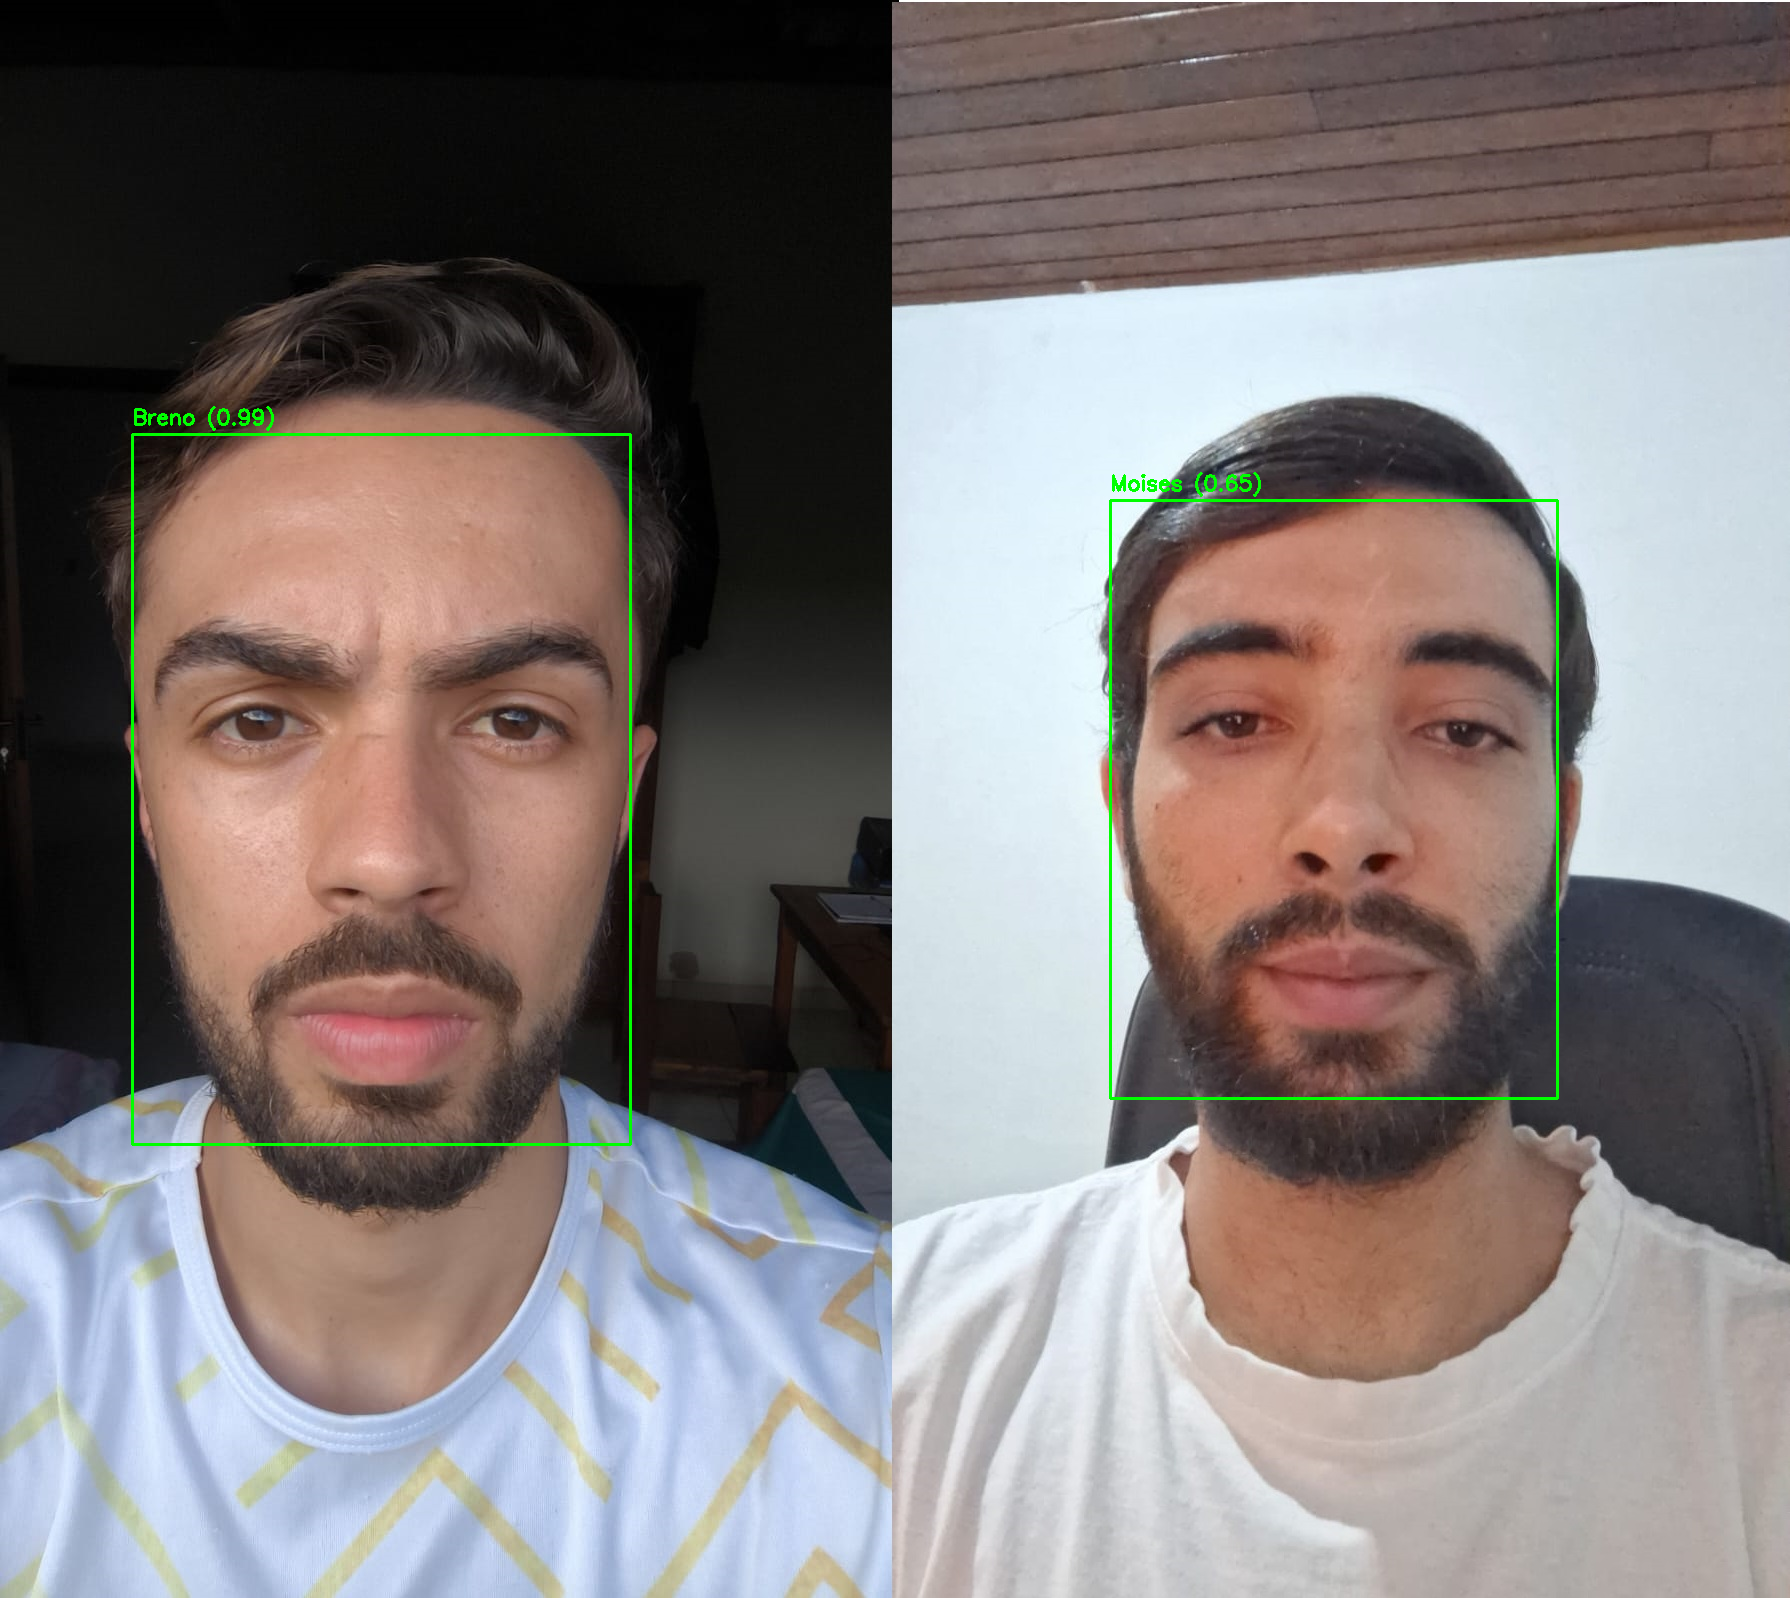

In [49]:
# Testar com uma nova imagem
detect_and_classify_faces("/content/drive/MyDrive/Deteccao_Classificacao/imagens/4.jpg")